# Analysis: Client Booze 'R' Us

Included below is an example of our predictive analysis using linear regression, applied to the Casey's General Store franchise. We aim to produce a modeling process that can successfully and accurately predict sales for a given storefront.

In this specific instance, given a dataset of transactions, we want to predict Casey's General Store's future monthly sales per storefront given 2017-2020 data. Monthly sales are estimated using total bottle sales multiplied by state bottle retail price.

We believe that this process can generate both accurate and meaningful predictions for Booze 'R' Us's average storefront sales.

# Setup

We use the following packages:
- `pandas` as a tool for tabular and relational data engineering
- `numpy` as a tool for vectorized mathematical operations
- `matplotlib` as a visualization tool
- `seaborn` as a statistical visualization tool
- `datetime` as a package for datetime data management and manipulation
- `holidays` as a package for identifying holidays for analytical purposes
- `itertools` to create combinations of variables with which to fit candidate models
- `squarify` as a visualization tool

In [ ]:
!pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import holidays
import itertools
import squarify

Here, we suppress unneccesary warnings for cleaner output.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Collection

Below, we read in a subset of the [Iowa Liquor Sales Data](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) that includes only Casey's General Store data from 2017-2020.

In [ ]:
df_init = pd.read_csv("https://www.dropbox.com/scl/fi/ioippropsqj7yyh24kmdg/Iowa_Liquor_Sales_Caseys.csv?rlkey=t5091uftolrhnpom6pv5lf1pr&dl=1")

The columns found in the raw data, along with their counts of non-null values and datatypes, can be found below:

In [ ]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396261 entries, 0 to 396260
Data columns (total 29 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Invoice/Item Number                 396261 non-null  object 
 1   Date                                396261 non-null  object 
 2   Store Number                        396261 non-null  int64  
 3   Store Name                          396261 non-null  object 
 4   Address                             395494 non-null  object 
 5   City                                395494 non-null  object 
 6   Zip Code                            395494 non-null  float64
 7   Store Location                      373976 non-null  object 
 8   County Number                       395494 non-null  float64
 9   County                              395494 non-null  object 
 10  Category                            396221 non-null  float64
 11  Category Name             

We will subset to only the variables that we need.

In [ ]:
df = df_init[['Store Number', 'Date', 'County', 'Pack', 'Bottle Volume (ml)', 'State Bottle Retail', 'Bottles Sold', 'Category Name', 'Sale (Dollars)', 'State Bottle Cost']]
df.head()

,Store Number,Date,County,Pack,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Category Name,Sale (Dollars),State Bottle Cost
0,4492,01/03/2017,LINN,24,375,12.00,24,CANADIAN WHISKIES,288.00,8.00
1,4492,01/03/2017,LINN,12,750,6.00,12,WHITE RUM,72.00,4.00
2,4623,01/03/2017,DALLAS,12,750,23.39,6,CANADIAN WHISKIES,135.66,15.59
3,4492,01/03/2017,LINN,24,375,2.70,24,AMERICAN VODKAS,64.80,1.80
4,4487,01/03/2017,LINN,24,375,7.13,12,AMERICAN VODKAS,85.56,4.75


## Feature Engineering

We seek to create or mutate the following variables for the transactional level data:
- Month: The month of the transaction
- Year: The year of the transaction
- Full Packs Sold: The number of bottles sold floor divided by pack size
- Single Bottles Sold: Specifically, single bottles sold in excess of full packs sold; this is calculated by taking the remainder of bottles sold after dividing by pack size.
- Bottle Size Category: Categorizes bottles into small or large. When reshaping the data to a per month-year-storefront basis, we count the number of bottles in each category sold in that month/year/storefront.
- Bottle Price Category: Categorizes bottles into cheap, midprice or expensive. When reshaping the data to a per month-year-storefront basis, we count the number of bottles in each category sold in that month/year/storefront.
- Alcohol Category: Categorizes bottles into more general liquor categories. When reshaping the data to a per month-year-storefront basis, we count the number of bottles in each category sold in that month/year/storefront.



### Mutating Categorical from Numeric Data

Here, we exploratively define the categories in the new Price Category and Bottle Size Category variables.

In [ ]:
bin_edges = [0, 10, 25, float('inf')]
bin_labels = ['Cheap (< 25)', 'Midprice (25-50)', 'Expensive (50+)']

df['Price Category'] = pd.cut(df.loc[:,"State Bottle Retail"], bins=bin_edges, labels=bin_labels)

value_counts = df['Price Category'].value_counts()
value_counts

Midprice (25-50)    198696
Cheap (< 25)        168736
Expensive (50+)      28829
Name: Price Category, dtype: int64

In [ ]:
bin_edges = [0, 750, float('inf')]
bin_labels = ['Small (<750)', 'Large (>=750)']

df['Bottle Size'] = pd.cut(df['Bottle Volume (ml)'], bins=bin_edges, labels=bin_labels)
value_counts2 = df['Bottle Size'].value_counts()
value_counts2

Small (<750)     325812
Large (>=750)     70449
Name: Bottle Size, dtype: int64

After this exploration, for Bottle Price Category, we define the following categories:
- Expensive: Greater than \$50
- Midprice: \$25 to \$50
- Cheap: Less than \$25

For Bottle Size Category, we define the following categories:
- Small: Greater than 800mL
- Large: Less than 800mL

### Defining Functions

We define custom functions here to apply in a vectorized manner to existing columns, in order to create new columns.

- `alc_type_cat`: Simplifies the alcohol types into fewer categories. Takes in an alcohol category, and returns a more general one.

In [ ]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

### Feature Creation

Below, we create the following feature for the transaction-level data: Month, Year, Full Packs Sold, Single Bottle Sold, Bottle Size Category, Alcohol Category

In [ ]:
df_train = df.loc[:, ['Store Number', 'Date', 'County', 'Pack', 'Bottle Volume (ml)', 'State Bottle Retail', 'Bottles Sold', 'Category Name', 'Sale (Dollars)']]
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Month'] = df_train['Date'].dt.month
df_train['Year'] = df_train['Date'].dt.year
df_train['Full Packs Sold'] = df_train['Bottles Sold'] // df_train['Pack']
df_train['Single Bottles Sold'] = df_train['Bottles Sold'] % df_train['Pack']
df_train['Bottle Size Category'] = pd.cut(x=df_train['Bottle Volume (ml)'],
                                          bins=[0, 750, np.infty],
                                          labels = ["SMALL", "LARGE"])
df_train['Bottle Price Category'] = pd.cut(x=df_train['State Bottle Retail'],
                                          bins=[0, 10, 25, np.infty],
                                          labels = ["CHEAP", "MIDPRICE", "EXPENSIVE"])
df_train['Alcohol Category'] = df_train['Category Name'].apply(alc_type_cat)
df_train.sort_values(['Store Number', 'Year', 'Month'], inplace=True)
df_train

,Store Number,Date,County,Pack,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Category Name,Sale (Dollars),Month,Year,Full Packs Sold,Single Bottles Sold,Bottle Size Category,Bottle Price Category,Alcohol Category
415,4463,2017-01-06,HANCOCK,12,750,12.38,3,AMERICAN FLAVORED VODKA,37.14,1,2017,0,3,SMALL,MIDPRICE,VODKA
436,4463,2017-01-06,HANCOCK,6,1750,10.76,6,AMERICAN VODKAS,64.56,1,2017,1,0,LARGE,MIDPRICE,VODKA
489,4463,2017-01-06,HANCOCK,12,750,7.50,3,AMERICAN CORDIALS & LIQUEURS,21.39,1,2017,0,3,SMALL,CHEAP,OTHER
522,4463,2017-01-06,HANCOCK,6,1750,10.38,6,AMERICAN VODKAS,62.28,1,2017,1,0,LARGE,MIDPRICE,VODKA
529,4463,2017-01-06,HANCOCK,6,1750,10.80,6,AMERICAN VODKAS,64.80,1,2017,1,0,LARGE,MIDPRICE,VODKA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390466,6064,2020-12-18,POLK,12,50,10.95,12,STRAIGHT BOURBON WHISKIES,131.40,12,2020,1,0,SMALL,MIDPRICE,WHISKY
390474,6064,2020-12-18,POLK,12,50,13.31,12,CREAM LIQUEURS,159.72,12,2020,1,0,SMALL,MIDPRICE,OTHER
390493,6064,2020-12-18,POLK,12,375,8.25,6,MIXTO TEQUILA,49.50,12,2020,0,6,SMALL,CHEAP,TEQUILA
390494,6064,2020-12-18,POLK,5,50,44.30,5,IMPORTED CORDIALS & LIQUEURS,221.50,12,2020,1,0,SMALL,EXPENSIVE,OTHER


## Data Reshaping

In this step, we aggregate the data into a month-year-storefront observation level. We convert the categorical variables into counts of each category, and then join with group sums of the numeric variables.

In [ ]:
agg_1 = df_train[['Store Number', 'Year', 'Month', 'Bottle Size Category']].value_counts().sort_index().unstack().reset_index()
agg_2 = df_train[['Store Number', 'Year', 'Month', 'Bottle Price Category']].value_counts().sort_index().unstack().reset_index()
agg_3 = df_train[['Store Number', 'Year', 'Month', 'Alcohol Category']].value_counts().sort_index().unstack().reset_index()
agg_4 = df_train[['Store Number', 'Year', 'Month', 'Full Packs Sold', 'Single Bottles Sold', 'Sale (Dollars)']].groupby(['Store Number', 'Year', 'Month']).sum().reset_index()
df_agg = agg_4.merge(agg_1, how="left", on=['Store Number', 'Year', 'Month']) \
  .merge(agg_2, how="left", on=['Store Number', 'Year', 'Month']) \
  .merge(agg_3, how="left", on=['Store Number', 'Year', 'Month']) \
  .fillna(0)
df_agg = df_agg.sort_values(['Store Number', 'Year', 'Month'])
df_agg.to_csv('client_a.csv')
df_agg

,Store Number,Year,Month,Full Packs Sold,Single Bottles Sold,Sale (Dollars),SMALL,LARGE,CHEAP,MIDPRICE,EXPENSIVE,BRANDY,GIN,OTHER,RUM,SCHNAPPS,SPIRITS,TEQUILA,VODKA,WHISKY
0,4463,2017,1,88,110,10317.89,56.0,50.0,25.0,75.0,6.0,1.0,2.0,9.0,12.0,10.0,0.0,0.0,40.0,32.0
1,4463,2017,2,86,139,10824.47,64.0,56.0,26.0,86.0,8.0,3.0,1.0,12.0,17.0,8.0,0.0,1.0,40.0,38.0
2,4463,2017,3,101,161,12745.05,83.0,56.0,36.0,95.0,8.0,0.0,2.0,18.0,14.0,13.0,0.0,2.0,45.0,45.0
3,4463,2017,4,99,161,12401.86,86.0,46.0,40.0,83.0,9.0,4.0,2.0,10.0,18.0,14.0,0.0,6.0,37.0,41.0
4,4463,2017,5,114,158,14075.23,77.0,67.0,42.0,91.0,11.0,2.0,1.0,16.0,21.0,10.0,1.0,5.0,49.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13159,6059,2020,12,8,0,1225.80,4.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
13160,6063,2020,10,45,168,7489.36,63.0,6.0,26.0,39.0,4.0,1.0,2.0,12.0,10.0,2.0,1.0,5.0,16.0,20.0
13161,6063,2020,11,5,0,1018.68,4.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
13162,6063,2020,12,9,10,1592.96,9.0,1.0,4.0,6.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,3.0


Above is our final dataset. Each year-month-storefront is an observation. Sale (Dollars) is the dependent feature we are trying to predict with the remaining features.

## Early Visuals

Here, we have produced exploratory visuals to help guide our variable selection and model creation process.

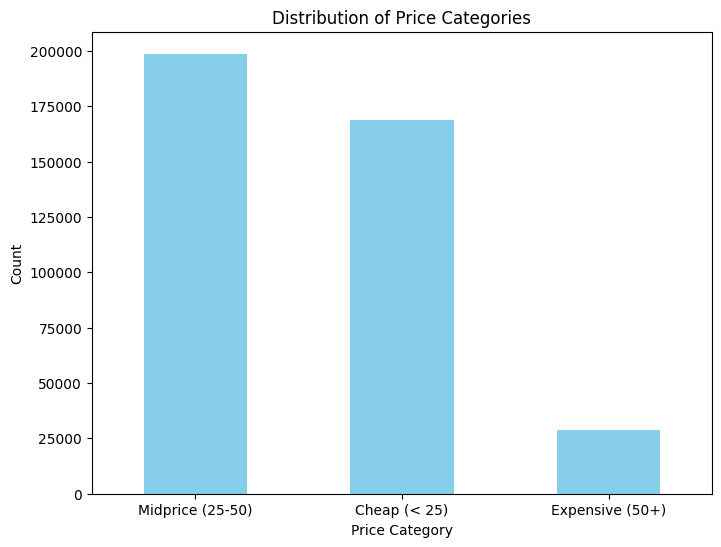

In [ ]:
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

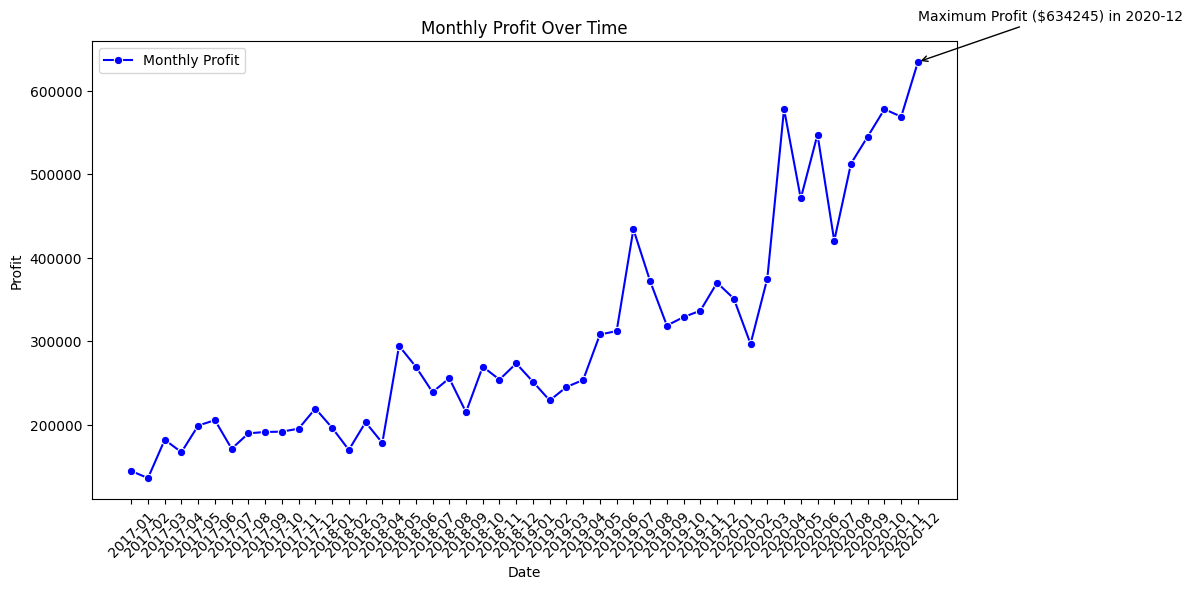

In [ ]:
iowa = pd.DataFrame()
iowa['Date'] = pd.to_datetime(df['Date'])
iowa['Profit'] = (df['State Bottle Retail'] * df['Bottles Sold']) - (df['State Bottle Cost'] * df['Bottles Sold'])
monthly_profit = iowa.groupby(iowa['Date'].dt.strftime('%Y-%m'))['Profit'].sum().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=monthly_profit, x='Date', y='Profit', marker='o', color='b', label='Monthly Profit')
ax.set(xlabel="Date", ylabel="Profit", title="Monthly Profit Over Time")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend()

max_profit_date = monthly_profit.loc[monthly_profit['Profit'].idxmax()]['Date']
max_profit = monthly_profit['Profit'].max()
plt.annotate(f"Maximum Profit (${max_profit:.0f}) in {max_profit_date}", xy=(max_profit_date, max_profit), xytext=(max_profit_date, max_profit + 50000),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()


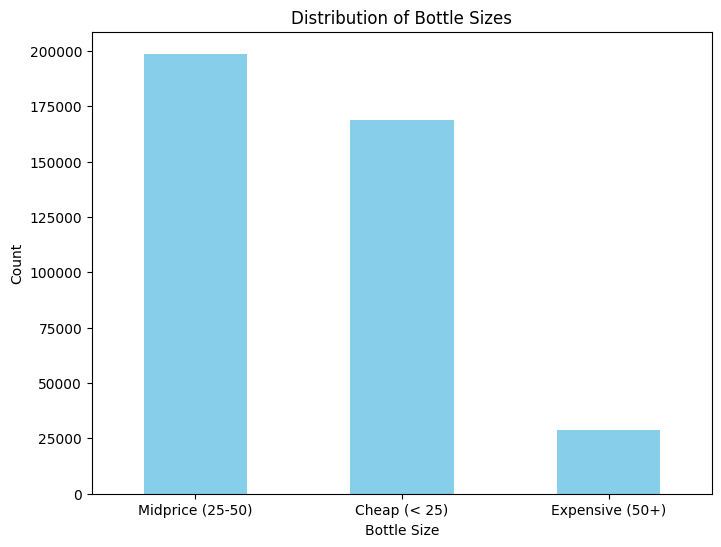

In [ ]:
bin_edges = [0, 750, float('inf')]
bin_labels = ['Small (<750)', 'Large (>=750)']

df['Bottle Size'] = pd.cut(df['Bottle Volume (ml)'], bins=bin_edges, labels=bin_labels)

value_counts2 = df['Bottle Size'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Bottle Sizes')
plt.xlabel('Bottle Size')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

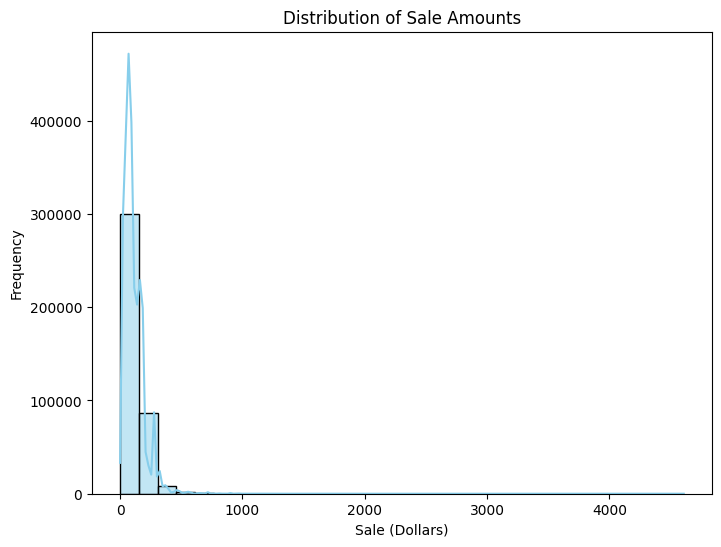

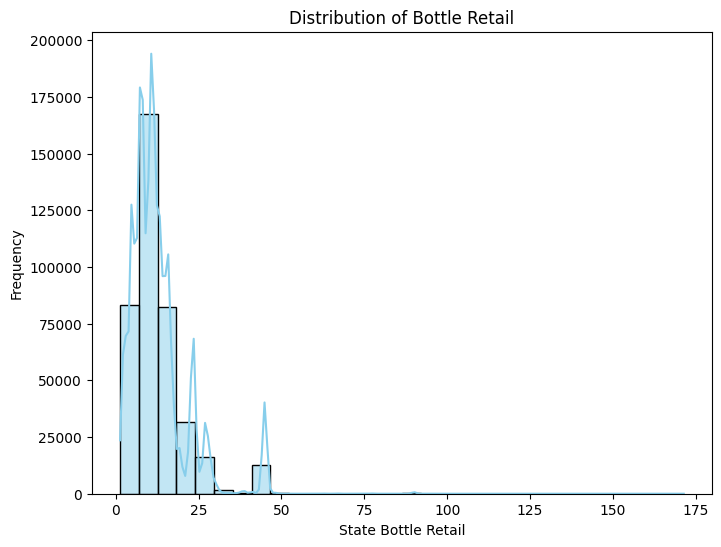

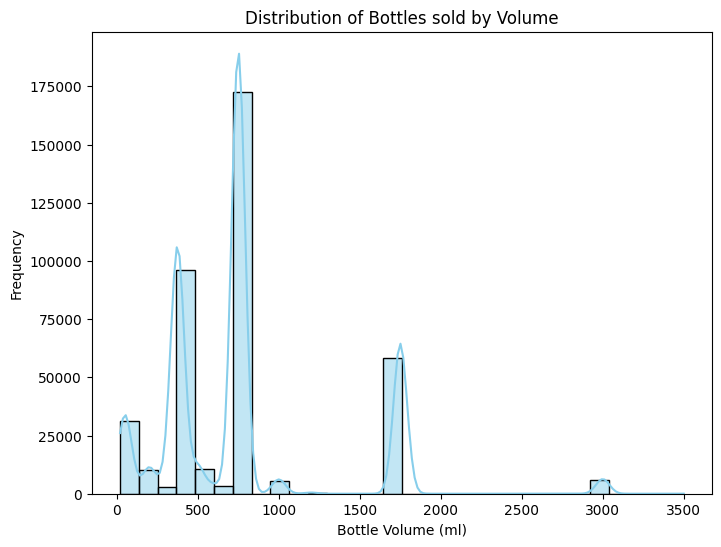

In [ ]:
# sale
plt.figure(figsize=(8, 6))
sns.histplot(df['Sale (Dollars)'], bins=30, kde=True, color='skyblue')
plt.xlabel('Sale (Dollars)')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Amounts')
plt.show()

# state bottle retail
plt.figure(figsize=(8, 6))
sns.histplot(df['State Bottle Retail'], bins=30, kde=True, color='skyblue')
plt.xlabel('State Bottle Retail')
plt.ylabel('Frequency')
plt.title('Distribution of Bottle Retail')
plt.show()

# bottle size
plt.figure(figsize=(8, 6))
sns.histplot(df['Bottle Volume (ml)'], bins=30, kde=True, color='skyblue')
plt.xlabel('Bottle Volume (ml)')
plt.ylabel('Frequency')
plt.title("Distribution of Bottles sold by Volume")
plt.show()

## Model Fitting

### Data

In [ ]:
df_liquor = pd.read_csv("https://raw.githubusercontent.com/mshsu/data403-project1/main/client_a.csv", low_memory=False)

In [ ]:
df_liquor = df_liquor.drop("Unnamed: 0", axis = 1)
df_liquor.head()

,Store Number,Year,Month,Full Packs Sold,Single Bottles Sold,Sale (Dollars),SMALL,LARGE,CHEAP,MIDPRICE,EXPENSIVE,BRANDY,GIN,OTHER,RUM,SCHNAPPS,SPIRITS,TEQUILA,VODKA,WHISKY
0,4463,2017,1,88,110,10317.89,56.0,50.0,25.0,75.0,6.0,1.0,2.0,9.0,12.0,10.0,0.0,0.0,40.0,32.0
1,4463,2017,2,86,139,10824.47,64.0,56.0,26.0,86.0,8.0,3.0,1.0,12.0,17.0,8.0,0.0,1.0,40.0,38.0
2,4463,2017,3,101,161,12745.05,83.0,56.0,36.0,95.0,8.0,0.0,2.0,18.0,14.0,13.0,0.0,2.0,45.0,45.0
3,4463,2017,4,99,161,12401.86,86.0,46.0,40.0,83.0,9.0,4.0,2.0,10.0,18.0,14.0,0.0,6.0,37.0,41.0
4,4463,2017,5,114,158,14075.23,77.0,67.0,42.0,91.0,11.0,2.0,1.0,16.0,21.0,10.0,1.0,5.0,49.0,39.0


We have elected to standardize the data in order to better evaluate effect size and evenly apply the penalty hyperparameter across the coefficients.

In [ ]:
# Standardizing

columns_to_standardize = ["Full Packs Sold", "Single Bottles Sold", "SMALL", "LARGE", "CHEAP", "MIDPRICE", "EXPENSIVE", "BRANDY", "GIN", "OTHER", "RUM", "SCHNAPPS", "SPIRITS", "TEQUILA", "VODKA", "WHISKY"]

for column in columns_to_standardize:
    df_liquor[column + "_std"] = (df_liquor[column] - df_liquor[column].mean()) / df_liquor[column].std()


### Functions

Here, we define custom functions created to perform ridge regression model creation, selection, and analysis (descriptions inline).

In [ ]:
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def ridge(X, Y, l, intercept):
  """
  Inputs:
    X: numpy array of predictors
    y: numpy array of value to predict
    l: lambda
    intercept: boolean flag; true if intercept in model false if not

  Compute beta estimate(s) for Ridge regression
  """
  if intercept:
    ones_col = np.ones((X.shape[0], 1))
    X = np.hstack((ones_col, X))

  return np.linalg.inv(X.T @ X + l * np.identity(X.shape[1])) @ (X.T @ Y)
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def try_many_lambdas(X, Y, l_lst, intercept):
  """
  Computes Ridge estimators for a list of lambda values where:
    loss = Sq Error
  """
  df_results = pd.DataFrame(data={"lambda": l_lst})
  results = df_results["lambda"].apply(lambda l: ridge(X, Y, l, intercept))

  return pd.DataFrame(results.tolist())
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice):
  """
  Compute chosen validation metric for a list of lambdas where:
    loss = Sq Error
  using test and training data

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df_train: df of training data
  df_test: df of testing data
  Y: String with name of response
  m_choice: an list of int(s) corresonding metric(s)
  """
  X_train = df_train.drop([Y], axis=1)
  X_test = df_test.drop([Y], axis=1)
  Y_train = df_train[Y]
  Y_test = df_test[Y]

  df_results = try_many_lambdas(X_train.to_numpy(), Y_train.to_numpy(), l_lst, intercept)

  if intercept:
    X_test.insert(0, "b0", 1)

  df_results["y_hat"] = df_results.apply(lambda row: X_test.to_numpy() @ row.to_numpy(), axis=1)
  df_results["lambda"] = l_lst

  n = len(Y_test)
  keep = ["lambda"]
  if 1 in m_choice:
    df_results["r_sqr"] = df_results.apply(lambda row: 1 - sum((Y_test - row["y_hat"]) ** 2) / sum((Y_test - Y_test.mean()) ** 2), axis=1)
    keep.append("r_sqr")

  if 2 in m_choice:
    df_results["MSE"] = df_results.apply(lambda row: 1 / n * sum((Y_test - row["y_hat"]) ** 2), axis=1)
    keep.append("MSE")

  if 3 in m_choice:
    df_results["MAE"] = df_results.apply(lambda row: sum(abs(Y_test - row["y_hat"])) / n, axis=1)
    keep.append("MAE")

  return df_results[keep]
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_cv(df, Y, l_lst, intercept, m_choice, n_split):
  """
  Compute avg chosen validation metric for a list of lambdas using v-fold cross-validation

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df: Pandas DataFrame of ONLY predictors and response
  Y: String with name of response
  intercept: boolean flag; true if intercept in model false if not
  m_choice: an list of int(s) corresonding metric(s)
  """
  df = df.sample(frac=1, random_state=43)
  fold_size = len(df) // n_split
  df["Fold"] = np.append(np.repeat(range(1, n_split+1), fold_size), np.repeat(n_split,len(df) % n_split))

  df_results = pd.DataFrame()
  for n in range(1, n_split+1):
    df_test = df[df["Fold"] == n].drop(["Fold"], axis=1)
    df_train = df[df["Fold"] != n].drop(["Fold"], axis=1)
    df_results = pd.concat([df_results, tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice)])

  return df_results.groupby("lambda").mean()
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def compare_B(B, X, Y):
  predictors = pd.DataFrame(X).columns.to_list()
  predictors.insert(0, "intercept")
  return pd.DataFrame({"B": ridge(X, Y, 10, True)}, index=predictors).sort_values("B", ascending=False)

### Models

Finally, we iterate through multiple linear regression models with various ridge penalties, in order to create a wide range of models from which to select a best model to predict sales as estimated by state bottle retail price multiplied by bottles sold.

We validate each model through k-fold cross-validation.

We have elected not to use variables regarding pure volume sold, such as Full Packs Sold and Single Bottles Sold, in order to create a model that provides more granular and meaningful insights into what drives sales. For instance, we know that selling more packs will result in higher total sales, but what type of packs will result in more sales? Small or Large? Vodka, or Gin? Cheap, or Expensive?

We seek to provide a more meaningful model in this way in, with a tradeoff of less overfitting.

In [ ]:
# Define the list of standardized variables
standardized_vars = [
    ["SMALL_std",
    "LARGE_std"],
    ["CHEAP_std",
    "MIDPRICE_std",
    "EXPENSIVE_std"],
    ["BRANDY_std",
    "GIN_std",
    "OTHER_std",
    "RUM_std",
    "SCHNAPPS_std",
    "SPIRITS_std",
    "TEQUILA_std",
    "VODKA_std",
    "WHISKY_std"]
]

# Create different combinations of variables
combinations = []
for r in range(1, len(standardized_vars) + 1):
    # Generate all combinations of 'r' variables
    from itertools import combinations as combo
    var_combinations = list(combo(standardized_vars, r))
    combinations.extend(var_combinations)

#### Model 0

In Model 0, we use variables relating to number of bottles sold by size, cost, and liquor category.

Our best $R^2$ occurs when we use a penalty of $\lambda=2$ to $10$.

In [ ]:
df_m0 = df_liquor[["Sale (Dollars)",
                   "SMALL_std",
                   "LARGE_std",
                   "CHEAP_std",
                   "MIDPRICE_std",
                   "EXPENSIVE_std",
                   "BRANDY_std",
                   "GIN_std",
                   "OTHER_std",
                   "RUM_std",
                   "SCHNAPPS_std",
                   "SPIRITS_std",
                   "TEQUILA_std",
                   "VODKA_std",
                   "WHISKY_std"]]

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m0, "Sale (Dollars)", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.675479,1.401749e+06,861.526728
2,0.675480,1.401748e+06,861.485089
3,0.675480,1.401747e+06,861.443459
4,0.675480,1.401746e+06,861.401912
5,0.675480,1.401745e+06,861.360504
10,0.675480,1.401745e+06,861.154159
100,0.675260,1.402707e+06,857.740406
1000,0.654987,1.490397e+06,857.131115


### Model 1

In Model 1, we use variables relating to number of bottles sold by size, cost, and liquor category. In addition, we add Year as a predictor to account and control for trend over time.

Our best $R^2$ occurs when we use a penalty of $\lambda=1$.

In [ ]:
df_m1 = df_liquor[["Sale (Dollars)",
                   "Year",
                   "SMALL_std",
                   "LARGE_std",
                   "CHEAP_std",
                   "MIDPRICE_std",
                   "EXPENSIVE_std",
                   "BRANDY_std",
                   "GIN_std",
                   "OTHER_std",
                   "RUM_std",
                   "SCHNAPPS_std",
                   "SPIRITS_std",
                   "TEQUILA_std",
                   "VODKA_std",
                   "WHISKY_std"]]

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m1, "Sale (Dollars)", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.675668,1.400935e+06,861.287039
2,0.675648,1.401024e+06,861.322308
3,0.675641,1.401053e+06,861.335427
4,0.675638,1.401066e+06,861.343013
5,0.675636,1.401074e+06,861.348381
10,0.675634,1.401084e+06,861.365309
100,0.675641,1.401065e+06,861.575947
1000,0.674576,1.405719e+06,865.138026


#### Model 2

In Model 2, we use variables relating to number of bottles sold by size, cost, and liquor category. In addition, we include Month as a predictor to account and control for seasonality.

Our best $R^2$ occurs when we use a penalty of $\lambda=1$ to $5$.

In [ ]:
df_m2 = df_liquor[["Sale (Dollars)",
                   "Month",
                   "SMALL_std",
                   "LARGE_std",
                   "CHEAP_std",
                   "MIDPRICE_std",
                   "EXPENSIVE_std",
                   "BRANDY_std",
                   "GIN_std",
                   "OTHER_std",
                   "RUM_std",
                   "SCHNAPPS_std",
                   "SPIRITS_std",
                   "TEQUILA_std",
                   "VODKA_std",
                   "WHISKY_std"]]

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m2, "Sale (Dollars)", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.676203,1.398671e+06,860.447891
2,0.676203,1.398670e+06,860.407613
3,0.676203,1.398669e+06,860.367631
4,0.676203,1.398670e+06,860.327987
5,0.676203,1.398672e+06,860.289038
10,0.676199,1.398695e+06,860.099805
100,0.675238,1.402918e+06,858.538294
1000,0.625461,1.618385e+06,933.407946


#### Automated Models

In addition to these models, we have iteratively and systematically determined a best subsets model by performing a grid search over combinations of variables.

In this code, we're focusing on optimizing a model based on a combination of R-squared (R2) and Mean Absolute Error (MAE). Here's a brief overview of the code:

Defining Variable Combinations and Weights: First, we define the standardized variable combinations we want to explore. We also set the weights w1 and w2 to balance our preference for R2 and MAE. Our priority metric is ${R^2}$, so it has a larger weight.

Creating a List for Storing Best Models: We create an empty list called best_models to store information about the best models for each combination.

Looping Through Variable Combinations: We then iterate through the standardized variable combinations, and for each combination, we do the following:

    a. We create a DataFrame (df_selected) by selecting the "Sale (Dollars)" column and the standardized variables in the current combination.

    b. We run a model for the selected combination using the tune_lambda_cv function and store the results in the results DataFrame.

    c. We calculate the combined metric, which is a weighted sum of R2 and a negative weighted sum of MAE. This metric combines the goodness of fit (R2) and the prediction error (MAE) into a single value.

    d. We identify the row with the maximum combined metric, which represents the best model according to our preferences.

    e. We extract and store information about the best model, including the features used, the best lambda, the best R2, and the best MAE.

    f. We append the information about the best model for this combination to the best_models list.

Displaying Results: After looping through all combinations, we print information about the best models, including the selected features, best lambda, best R2, and best MAE.

By calculating a combined metric, we can make trade-offs between maximizing R2 and minimizing MAE to select the models that best suit our specific goals and priorities. We can adjust the weights (w1 and w2) as needed to emphasize one metric over the other.

In [ ]:
best_models = []  # List to store best models for each combination
l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]

# Define weights for R-squared and MAE
w1 = 0.7  # Weight for R2
w2 = 0.3  # Weight for MAE

best_models = []  # List to store best models for each combination

# Loop through standardized variable combinations
for combination in combinations:
    # Create a DataFrame with the selected standardized variables
    flat_list = list(itertools.chain(*combination))
    selected_columns = ["Sale (Dollars)"] + flat_list
    df_selected = df_liquor[selected_columns]

    # Run your model for this combination
    results = tune_lambda_cv(df_selected, "Sale (Dollars)", l_lst, True, [1, 2, 3], 5)
    results = results.reset_index()

    # Calculate the combined metric
    results['Combined Metric'] = w1 * results['r_sqr'] - w2 * results['MAE']

    # Find the row with the maximum combined metric
    best_combined_metric_row = results.loc[results['Combined Metric'].idxmax()]

    # Extract the best lambda, R-squared, and MAE
    best_lambda = best_combined_metric_row['lambda']
    best_r_sqr = best_combined_metric_row['r_sqr']
    best_mae = best_combined_metric_row['MAE']

    # Store the results for this combination in a dictionary
    best_model_info = {
        "Features": combination,
        "Best Lambda": best_lambda,
        "Best R-squared": best_r_sqr,
        "Best MAE": best_mae
    }

    best_models.append(best_model_info)

best_models_df = pd.DataFrame(best_models)

In [ ]:
print(best_models_df.to_string())

                                                                                                                                                                       Features  Best Lambda  Best R-squared    Best MAE
0                                                                                                                                                     ([SMALL_std, LARGE_std],)        100.0        0.651844  881.636139
1                                                                                                                                   ([CHEAP_std, MIDPRICE_std, EXPENSIVE_std],)        100.0        0.670986  862.951187
2                                                                   ([BRANDY_std, GIN_std, OTHER_std, RUM_std, SCHNAPPS_std, SPIRITS_std, TEQUILA_std, VODKA_std, WHISKY_std],)        100.0        0.655305  883.646922
3                                                                                                            ([SMALL_std, LARGE_std]

After performing this systematic process, we find the above models to be our best candidates based on validation metrics.

We will compare all of these models both using validation metrics and domain knowledge to select a final, meaningful sales prediction model.

## Final Model

From a preliminary analysis, we have chosen our final model to be model 2. We chose this because the $R^2$ is sufficiently high. Additionally, the model contains meaningful predictors regarding sales volume of bottle size, cost, and liquor type on top of accounting for seasonality by including the month predictor.

In [ ]:
tune_lambda_cv(df_m2, "Sale (Dollars)", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.676203,1.398671e+06,860.447891
2,0.676203,1.398670e+06,860.407613
3,0.676203,1.398669e+06,860.367631
4,0.676203,1.398670e+06,860.327987
5,0.676203,1.398672e+06,860.289038
10,0.676199,1.398695e+06,860.099805
100,0.675238,1.402918e+06,858.538294
1000,0.625461,1.618385e+06,933.407946


In [ ]:
X = df_m2.drop(["Sale (Dollars)"], axis=1)
Y = df_m2["Sale (Dollars)"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 1, True)
df_B = compare_B(B, X, Y)

y_labels = {'MIDPRICE_std': 'Midprice', 'OTHER_std': 'Other Alcohol',
            'EXPENSIVE_std': 'Expensive', 'RUM_std': 'Rum', 'GIN_std': 'Gin',
            'SCHNAPPS_std': 'Schnapps', 'SPIRITS_std': 'Spirits',
            'TEQUILA_std': 'Tequila', 'VODKA_std': 'Vodka', 'CHEAP_std': 'Cheap',
            'WHISKY_std': 'Whisky', 'CostPerLiter_std': 'Cost Per Liter',
            'LARGE_std': 'Large', 'Month': 'Month', 'BRANDY_std': 'Brandy',
            'SMALL_std': 'Small', 'intercept': 'Intercept'}

df_B = df_B.drop('intercept',axis=0)
df_B = df_B.reset_index()
df_B['index'] = df_B['index'].map(y_labels)
df_B['abs B'] = abs(df_B['B'])
df_B.sort_values('abs B', ascending=False)[['index', 'B']]

,index,B
0,Midprice,463.401300
1,Other Alcohol,325.596430
2,Expensive,300.114538
3,Vodka,278.446782
4,Small,214.931843
5,Whisky,182.812963
14,Cheap,-154.434688
6,Large,139.739836
7,Gin,115.832701
8,Tequila,95.625662


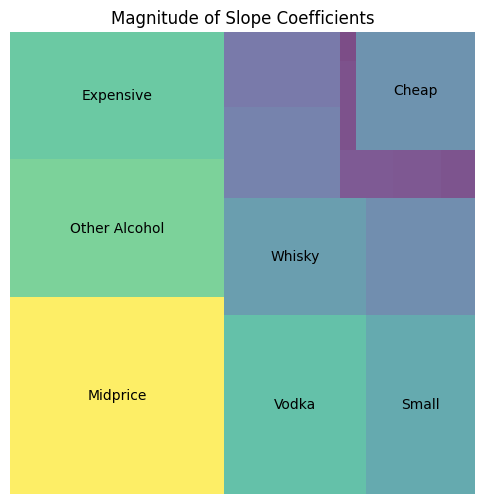

In [ ]:
filtered_labels = [label if size >= 150 else '' for label, size in zip(df_B['index'], df_B['abs B'])]

norm = plt.Normalize(min(df_B['abs B']), max(df_B['abs B']))
colors = [plt.cm.viridis(norm(value)) for value in df_B['abs B']]
plt.figure(figsize=(6, 6))
squarify.plot(sizes=df_B['abs B'], label=filtered_labels, color=colors, alpha=0.7)
plt.axis('off')
plt.title('Magnitude of Slope Coefficients')

plt.show()

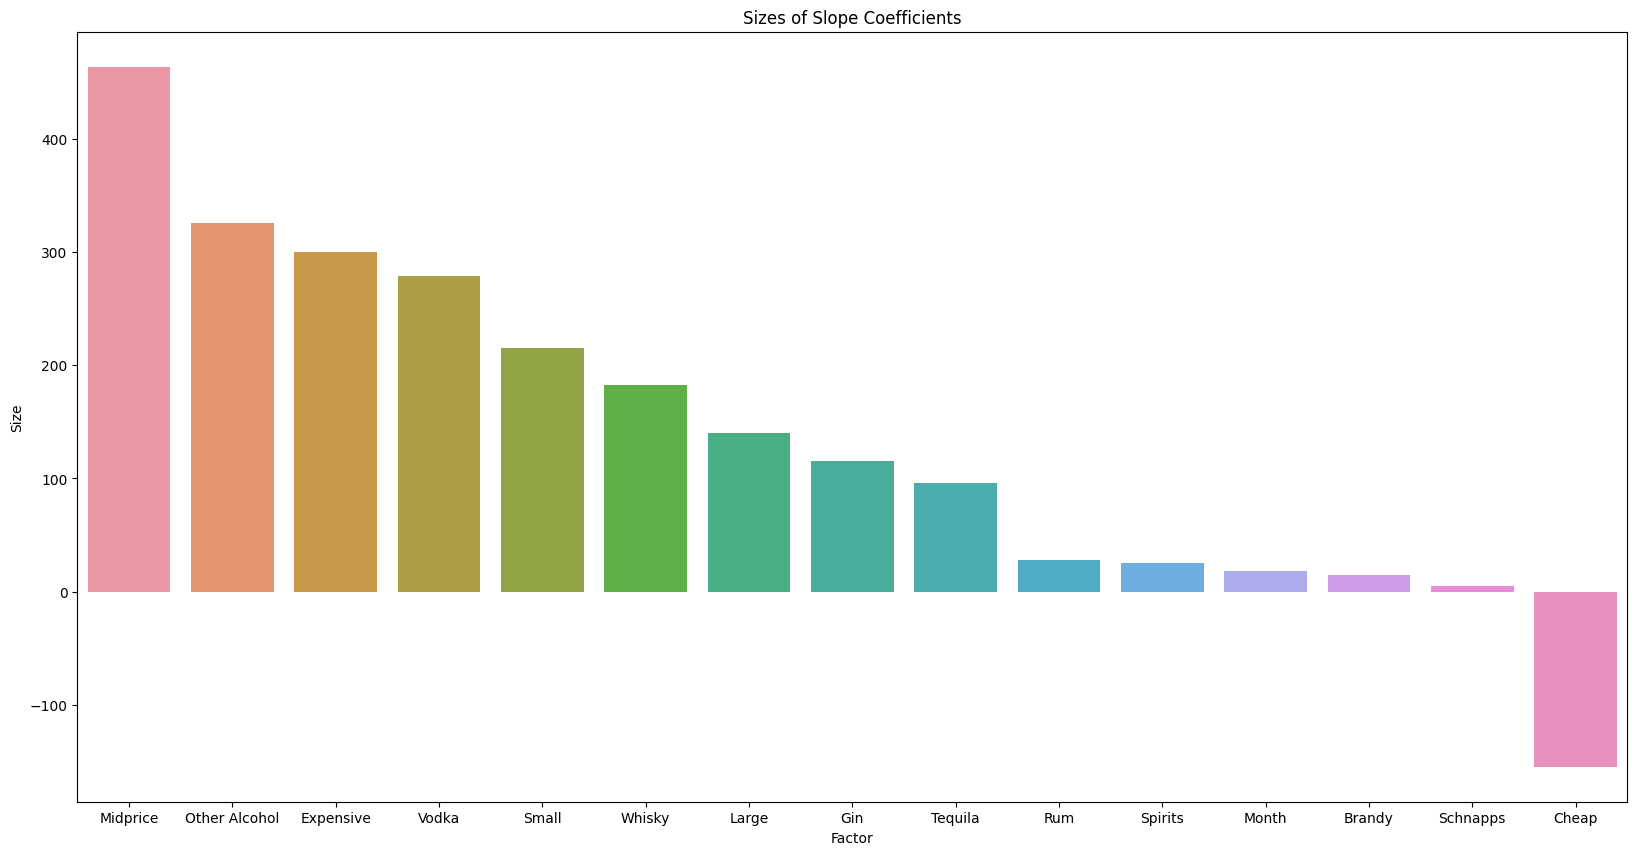

In [ ]:
# ADDED FOR FINAL REPORT (POST PRESENTATION)
import seaborn as sns
plt.figure(figsize=(20, 10))
p = sns.barplot(x=df_B['index'], y=df_B['B'])
plt.title('Sizes of Slope Coefficients')
p.set_ylabel('Size')
p.set_xlabel('Factor')

plt.show()

From the tree map visualization above, we can see that the predictors affecting sales the most include:
- Number of expensive, midprice, and cheap bottles sold
- Number of small bottles sold
- Number of whisky and other alcohol bottles sold.

In [ ]:
b = df_B['B']
b.index = df_B['index']
pred = (b.loc['Intercept'] +
        b.loc['Midprice'] * df_liquor['MIDPRICE_std'] +
        b.loc['Other Alcohol'] * df_liquor['OTHER_std'] +
        b.loc['Expensive'] * df_liquor['EXPENSIVE_std'] +
        b.loc['Vodka'] * df_liquor['VODKA_std'] +
        b.loc['Small'] * df_liquor['SMALL_std'] +
        b.loc['Whisky'] * df_liquor['WHISKY_std'] +
        b.loc['Large'] * df_liquor['LARGE_std'] +
        b.loc['Gin'] * df_liquor['GIN_std'] +
        b.loc['Tequila'] * df_liquor['TEQUILA_std'] +
        b.loc['Rum'] * df_liquor['RUM_std'] +
        b.loc['Spirits'] * df_liquor['SPIRITS_std'] +
        b.loc['Month'] * df_liquor['Month'] +
        b.loc['Brandy'] * df_liquor['BRANDY_std'] +
        b.loc['Schnapps'] * df_liquor['SCHNAPPS_std'] +
        b.loc['Cheap'] * df_liquor['CHEAP_std'])

df_pred = pd.DataFrame()
df_pred['pred'] = pred
df_pred['obs'] = df_liquor['Sale (Dollars)']
df_pred['month'] = df_liquor['Month']
df_pred['year'] = df_liquor['Year']
df_pred = df_pred.groupby(['year', 'month']).mean()
df_pred = df_pred.reset_index()
df_pred

,year,month,pred,obs
0,2017,1,2721.616338,2637.042454
1,2017,2,2707.425027,2525.317062
2,2017,3,3243.474596,3014.786167
3,2017,4,2945.850953,2813.029548
4,2017,5,3165.202744,3016.866802
5,2017,6,3274.024902,3196.223958
6,2017,7,2949.128603,2691.234684
7,2017,8,3152.703750,2970.294660
8,2017,9,3146.071156,2997.117539
9,2017,10,3143.603256,2855.278829


In [ ]:
df_pred['date'] = df_pred['year'].astype(str) + '-' + df_pred['month'].astype(str)

df_pred['date'] = pd.to_datetime(df_pred['date'], format='%Y-%m')
df_pred.set_index('date', inplace=True)
df_pred.sort_index(inplace=True)

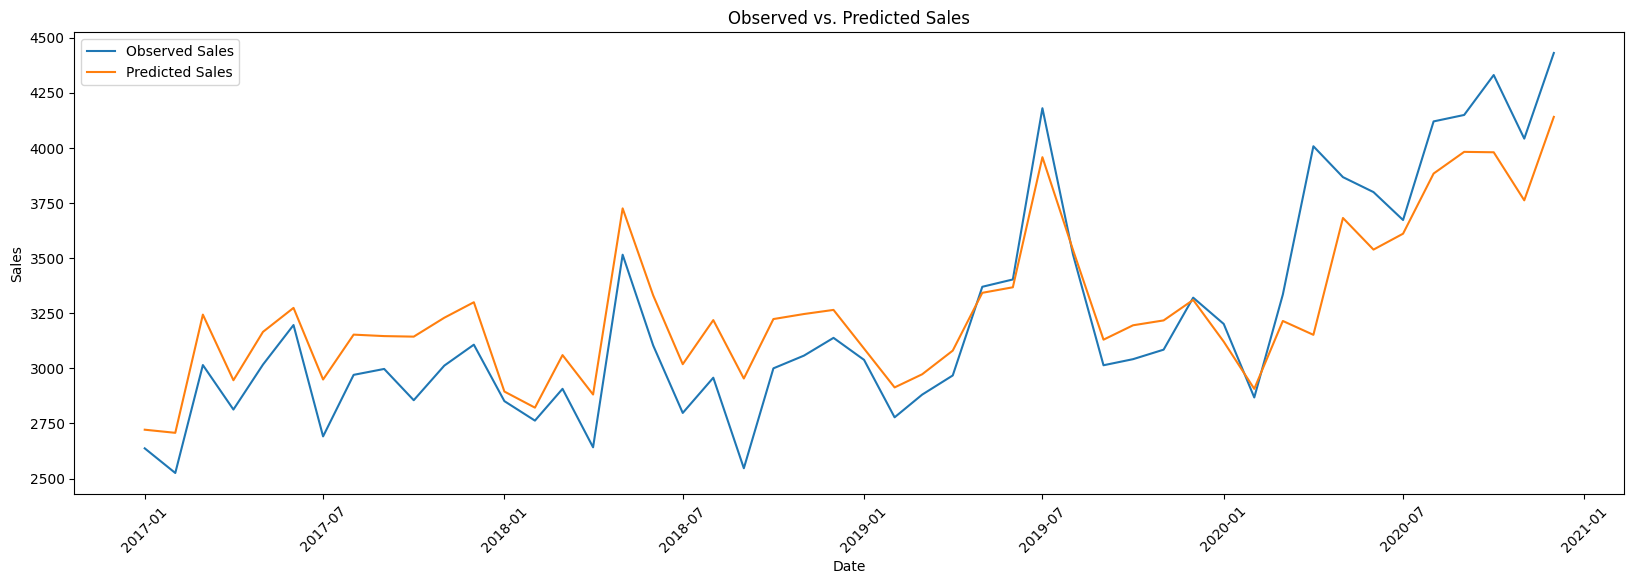

In [ ]:
plt.figure(figsize=(20, 6))  # Set the figure size

# Plot observed sales
sns.lineplot(data=df_pred, x=df_pred.index, y='obs', label='Observed Sales')

# Plot predicted sales
sns.lineplot(data=df_pred, x=df_pred.index, y='pred', label='Predicted Sales')

# Customize the plot
plt.title('Observed vs. Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
plt.legend()  # Display legend

plt.show()